# Multi-trait LMMs

### Set up the environment

In [1]:
%matplotlib inline
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

import sys
import scipy as sp
import numpy as np
import scipy.stats as st
import pylab as pl
import pandas as pd
import h5py
sp.random.seed(0)

import limix.util as lmx_util
import limix.plot as lmx_plt

def no_annotate(*args):
    pass
from limix.plot import manhattan
manhattan._annotate = no_annotate

### Download the data

First, load the yeast data, which have been imported into an hdf5 file. 

To process your own data, use the limix command line binary (see [here](http://nbviewer.jupyter.org/github/limix/limix-tutorials/blob/master/preprocessing_QC/loading_files.ipynb) for an example).

In [2]:
sys.path.append('./..')
import data as tutorial_data
file_name = tutorial_data.get_file('BYxRM')

### Set up the data object

The data object allows us to query the genotype and phenotype data.

In [3]:
f = h5py.File(file_name, 'r')
pheno_group = f['phenotype']
pheno_df = pd.DataFrame(pheno_group['matrix'][:], 
                        columns=np.char.decode(pheno_group['col_header']['phenotype_ID'][:]),
                        index=np.char.decode(pheno_group['row_header']['sample_ID'][:]))

In [4]:
pheno_df.shape

(1008, 46)

In [5]:
pheno_df.head()

,Cadmium_Chloride,Caffeine,Calcium_Chloride,Cisplatin,Cobalt_Chloride,Congo_red,Copper,Cycloheximide,Diamide,E6_Berbamine,...,x6-Azauracil,Xylose,YNB,YNB:ph3,YNB:ph8,YPD,YPD:15C,YPD:37C,YPD:4C,Zeocin
A01_01,-7.323520,0.279993,0.313118,1.658179,-1.604442,5.841617,-4.130950,0.821226,3.622602,-0.378747,...,1.199054,-0.309149,17.470822,0.055225,-0.184268,24.548971,0.712171,0.890842,4.118372,8.592818
A01_02,-8.098236,-0.206326,-0.534844,-0.918012,0.892198,-1.618172,1.131947,-0.764736,-2.946279,-2.475193,...,0.443182,0.697908,18.052925,0.283462,1.662201,26.808476,-1.522498,0.006062,0.066515,-4.220476
A01_03,7.605720,-0.127960,-0.311102,-2.712088,3.301709,-6.680571,-1.138056,-3.382532,-3.157866,-4.178616,...,1.472629,1.474329,18.163782,-0.951379,0.369565,26.183975,1.082289,1.723157,5.714088,-6.506519
A01_04,-6.147649,0.878392,-0.563331,-0.827358,-1.291270,2.753851,-2.268121,0.867456,-6.832079,-1.970630,...,0.054694,-0.739040,15.575856,-1.690867,-0.840344,20.893646,-0.636280,0.053258,-3.196936,0.294462
A01_05,9.379060,-1.353169,0.405204,-1.137234,4.260286,-7.391216,-3.222742,1.586376,1.048391,-3.971730,...,0.267463,0.959138,17.808444,0.127621,1.967267,28.621507,-3.720999,-0.768724,-4.002786,7.045575


In [6]:
geno_group = f['genotype']
chromosomes = geno_group['col_header']['chrom'][:]
positions = geno_group['col_header']['pos'][:]
geno_df = pd.DataFrame(geno_group['matrix'][:], columns=positions, 
                       index=np.char.decode(geno_group['row_header']['sample_ID'][:]),
                      dtype='int64')

In [7]:
geno_df.shape

(1008, 11623)

In [8]:
geno_df.head()

,27915,28323,28652,29667,30756,31059,31213,31636,31756,31976,...,925487,925742,926177,927903,928103,929518,929724,930545,931289,931944
A01_01,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
A01_02,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
A01_03,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,1,1
A01_04,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
A01_05,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


### Visualize the correlation among traits

In [9]:
#Remove NaNs
filtered_pheno_df = pheno_df.dropna()
phenotype_names = filtered_pheno_df.columns
# center phenotype
normalized_pheno_df = (filtered_pheno_df - filtered_pheno_df.mean()) / filtered_pheno_df.std()

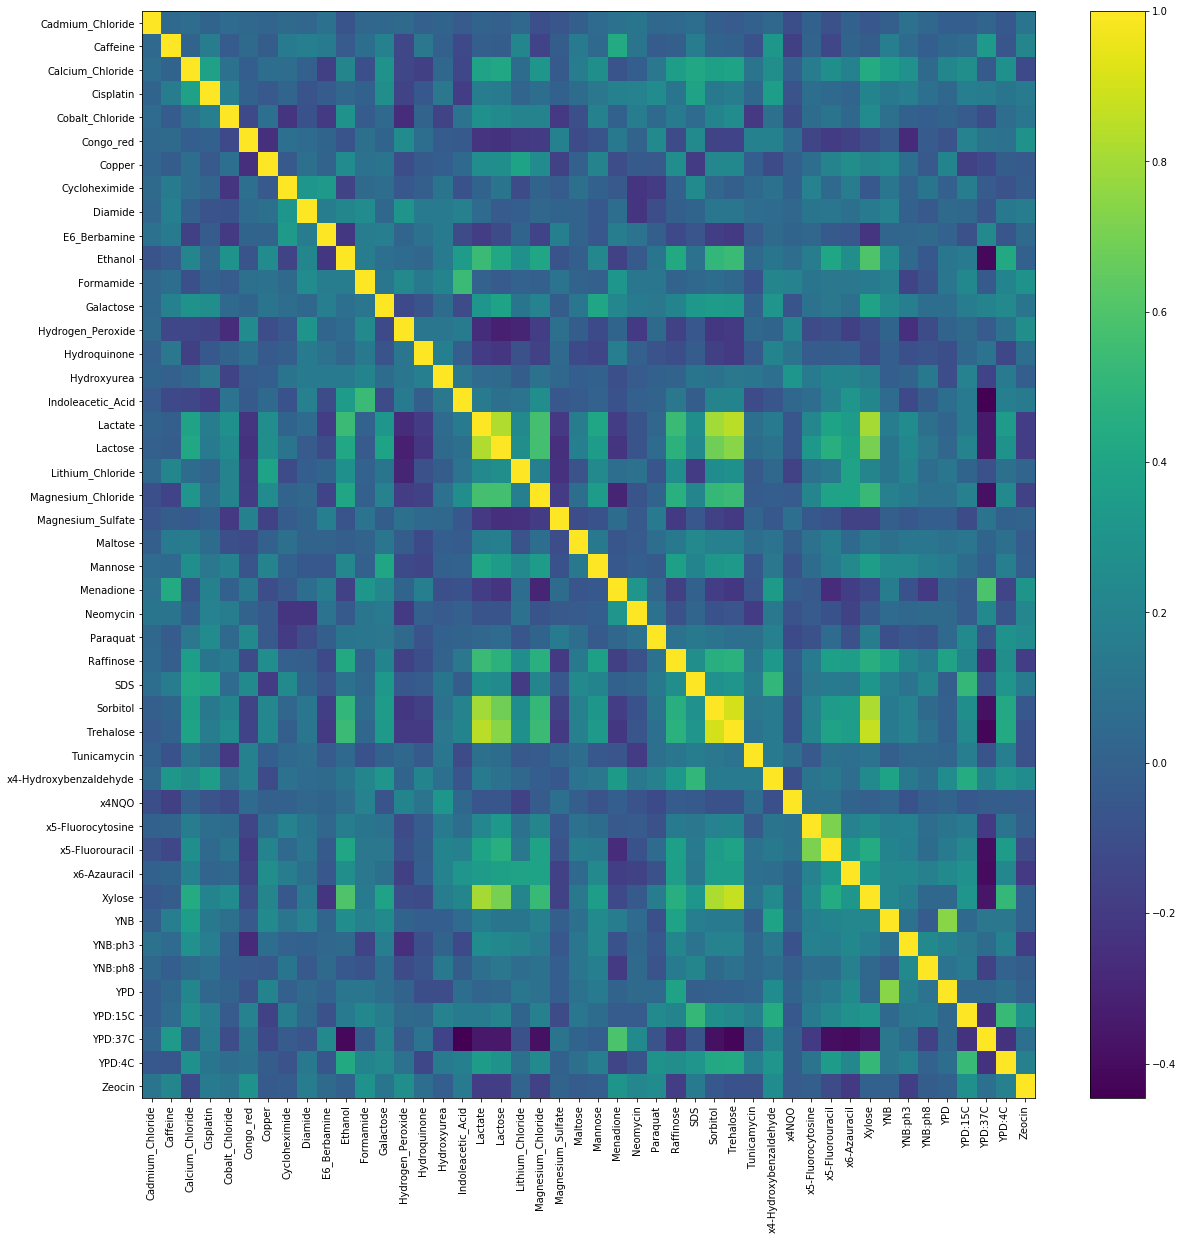

In [10]:
pl.figure(figsize=[20,20])
Ce= np.cov(normalized_pheno_df.values.T)
pl.imshow(Ce,aspect='auto',interpolation='none')
pl.xticks(np.arange(len(phenotype_names)),phenotype_names,rotation=90)
pl.yticks(np.arange(len(phenotype_names)),phenotype_names,rotation=0)
pl.colorbar()

### Select a subset of the phenotypes

In [11]:
phenotype_names = ['YPD:37C','YPD:15C','YPD:4C']
data_subsample = pheno_df[phenotype_names]

In [12]:
phenotypes = data_subsample.dropna() 
sample_idx = phenotypes.index.intersection(geno_df.index)
phenotypes = phenotypes.loc[sample_idx]
phenotypes = (phenotypes - phenotypes.mean()) / phenotypes.std()
phenotypes.describe()

,YPD:37C,YPD:15C,YPD:4C
count,8.040000e+02,8.040000e+02,8.040000e+02
mean,-2.651279e-17,2.209399e-18,5.744438e-17
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.651086e+00,-2.497574e+00,-2.020168e+00
25%,-7.669938e-01,-7.652285e-01,-7.548557e-01
50%,4.068578e-02,-7.631450e-02,-1.699190e-01
75%,8.097791e-01,7.221308e-01,6.011856e-01
max,2.867696e+00,2.745373e+00,3.382201e+00


We start by (further) examining the correlation among the phenotypes:

Text(0,0.5,'YPD:4C')

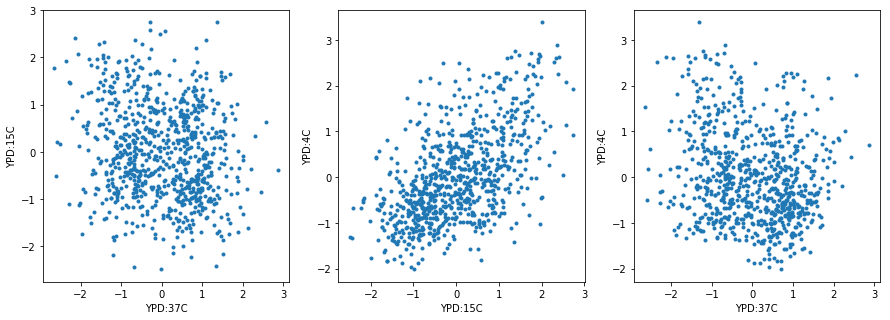

In [13]:
#pairwise corrrelations of the first 3 traits
pl.figure(figsize=[15,5])
pl.subplot(1,3,1)
pl.plot(phenotypes[phenotype_names[0]].values,phenotypes[phenotype_names[1]].values,'.')
pl.xlabel(phenotype_names[0])
pl.ylabel(phenotype_names[1])

pl.subplot(1,3,2)
pl.plot(phenotypes[phenotype_names[1]].values,phenotypes[phenotype_names[2]].values,'.')
pl.xlabel(phenotype_names[1])
pl.ylabel(phenotype_names[2])

pl.subplot(1,3,3)
pl.plot(phenotypes[phenotype_names[0]].values,phenotypes[phenotype_names[2]].values,'.')
pl.xlabel(phenotype_names[0])
pl.ylabel(phenotype_names[2])

# Variance Decomposition

Here, we show how to estimate the genetic and residual covariance using the limix class limix.varDecomp.VarianceDecomposition (see [here](https://www.pydoc.io/pypi/limix-1.0.6/autoapi/varDecomp/varianceDecomposition/index.html)).

In [14]:
from limix.vardec import VarianceDecomposition

In [15]:
# genetic relatedness matrix
from limix.stats import linear_kinship, gower_norm
sample_relatedness = gower_norm(linear_kinship(geno_df.loc[sample_idx].values))

100%|██████████| 100/100 [00:00<00:00, 421.01it/s]


In [16]:
# variance component model
vc = VarianceDecomposition(phenotypes.values)
vc.addFixedEffect()
vc.addRandomEffect(K=sample_relatedness)
vc.addRandomEffect(is_noise=True)
vc.optimize()

# retrieve genetic and noise covariance matrix
Cg = vc.getTraitCovar(0)
Cn = vc.getTraitCovar(1)

### Empirical Correlation

In [17]:
Ce = np.corrcoef(phenotypes.T)

### Plot the correlation among the phenotypes (empirical), the genetic covariance among phenotypes, and the noise covariance.

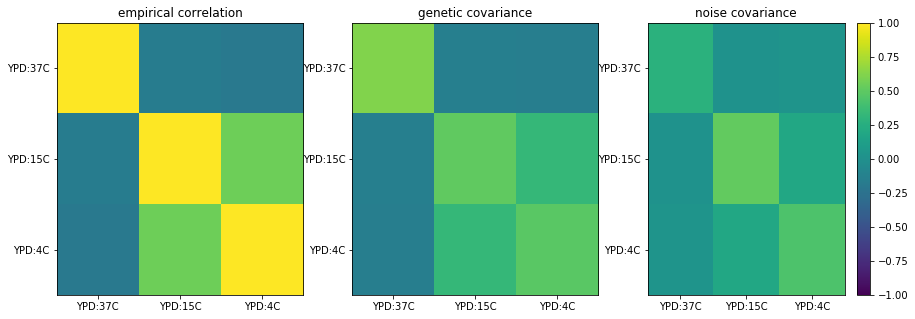

In [18]:
pl.figure(figsize=[15,5])
pl.subplot(1,3,1)
pl.imshow(Ce,aspect='auto',interpolation='none',vmin=-1,vmax=1)
pl.xticks(np.arange(len(phenotype_names)),phenotypes.columns)
pl.yticks(np.arange(len(phenotype_names)),phenotypes.columns)
pl.title('empirical correlation')

pl.subplot(1,3,2)
pl.imshow(Cg,aspect='auto',interpolation='none',vmin=-1,vmax=1)
pl.xticks(np.arange(len(phenotype_names)),phenotypes.columns)
pl.yticks(np.arange(len(phenotype_names)),phenotypes.columns)
pl.title('genetic covariance')

pl.subplot(1,3,3)
pl.imshow(Cn,aspect='auto',interpolation='none',vmin=-1,vmax=1)
pl.xticks(np.arange(len(phenotype_names)),phenotypes.columns)
pl.yticks(np.arange(len(phenotype_names)),phenotypes.columns)
pl.title('noise covariance')
pl.colorbar()

# Univariate association testing

As shown earlier, univariate (single-trait) association testing with linear mixed models can be performed with the function ``limix.qtl.qtl_test_lmm`` (see [here](https://limix.readthedocs.io/en/stable/qtl.html#linear-mixed-models)).


In [19]:
from limix.qtl import qtl_test_lmm

In [20]:
# load snp data
snps = geno_df.loc[sample_idx].values
positions = geno_df.columns

Run the LMM and convert the P-values into a pandas DataFrame.

In [21]:
lmm = qtl_test_lmm(snps=snps,
                   pheno=phenotypes.values,
                   K=sample_relatedness)
pv_lmm = lmm.getPv()

pvalues_lmm = pd.DataFrame(data=pv_lmm.T,
                           index=positions,
                           columns=phenotype_names)

Plot the results from (univariate) GWAS using Manhattan plots.

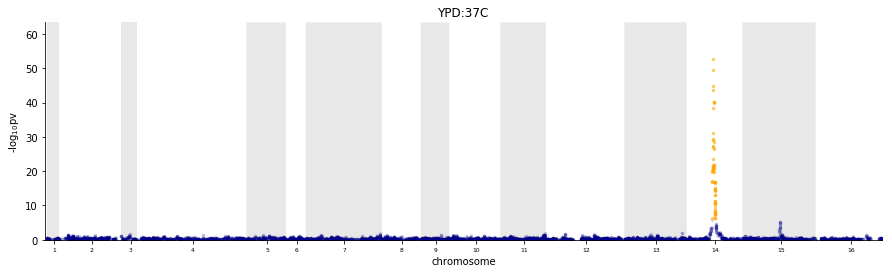

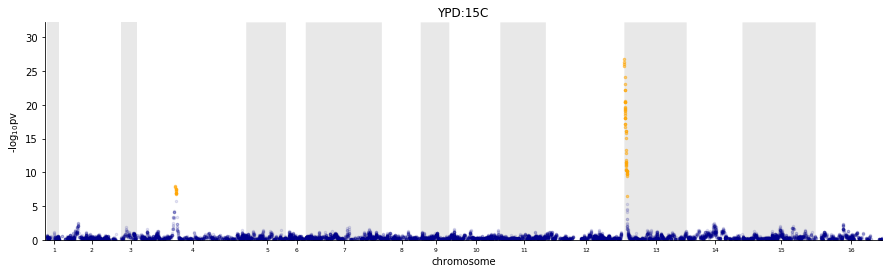

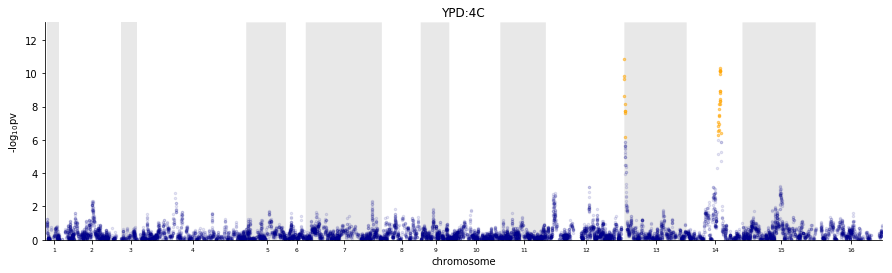

In [22]:
for p_ID in phenotype_names:
    pl.figure(figsize=[15,4])
    lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_lmm[p_ID].values,pos=positions,chrom=chromosomes,alpha=0.05)))
    pl.title(p_ID)

# Multi-trait association testing

Multi-trait association testing with linear mixed models can be performed using the function ``limix.qtl.qtl_test_lmm_kronecker`` (see [here](https://limix.readthedocs.io/en/stable/qtl.html#limix.qtl.qtl_test_lmm_kronecker)).

Here we show how to perform the following multi-trait tests:
- any effect test (that is, a test to determine if a SNP has an effect on any of the phenotypes)
- common effect test (test to determine if a SNP has the same effect size and sign/direction for both phenotypes)
- specific effect test (test to determine if a SNP has a specific effect on the two traits; good for GxE)

### Any effect test

In [23]:
N, P = phenotypes.values.shape

In [24]:
covs = np.ones((N, 1))      #covariates
Acovs = np.eye(P)           #the design matrix for the covariates   
Asnps = np.eye(P)           #the design matrix for the SNPs
K1r = sample_relatedness    #the first sample-sample covariance matrix (non-noise)

In [25]:
from limix.qtl import qtl_test_lmm_kronecker

In [26]:
lmm, pvalues = qtl_test_lmm_kronecker(snps=snps,
                                      phenos=phenotypes.values,
                                      covs=covs,
                                      Acovs=Acovs,
                                      Asnps=Asnps,
                                      K1r=K1r)

Convert the P-values into a DataFrame:

In [27]:
pvalues = pd.DataFrame(data=pvalues.T,index=positions,columns=['multi_trait'])

### Plot the results from multi-trait GWAS using Manhattan plots.

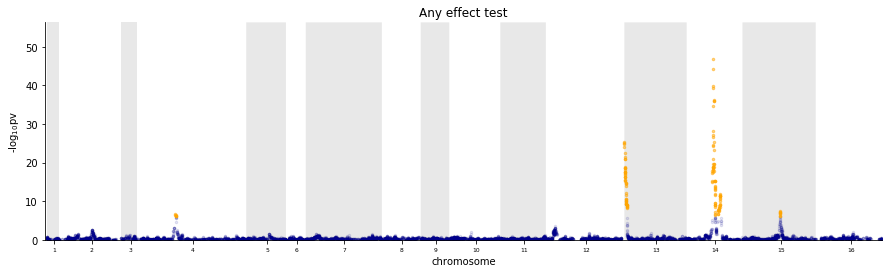

In [28]:
pl.figure(figsize=[15,4])
pl.title('Any effect test')
lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues['multi_trait'].values,
                       pos=positions,chrom=chromosomes)))

### Common effect test

A common effect test is a 1 degree of freedom test and can be done by setting
\begin{equation}
\mathbf{A}_1^\text{(snp)} = \mathbf{1}_{1,P},\;\;\;
\mathbf{A}_0^\text{(snp)} = \mathbf{0}
\end{equation}

In [29]:
covs = np.ones((N, 1))      #covariates
Acovs = np.eye(P)           #the design matrix for the covariates   
Asnps = np.ones((1,P))      #the design matrix for the SNPs
K1r = sample_relatedness    #the first sample-sample covariance matrix (non-noise)

In [30]:
lmm, pvalues_common = qtl_test_lmm_kronecker(snps=snps,
                                             phenos=phenotypes.values,
                                             #covs=covs,
                                             #Acovs=Acovs,
                                             Asnps=Asnps,
                                             K1r=K1r)

Convert the P-values into a DataFrame:

In [31]:
pvalues_common = pd.DataFrame(data=pvalues_common.T,index=positions,columns=['common'])

### Manhattan plot

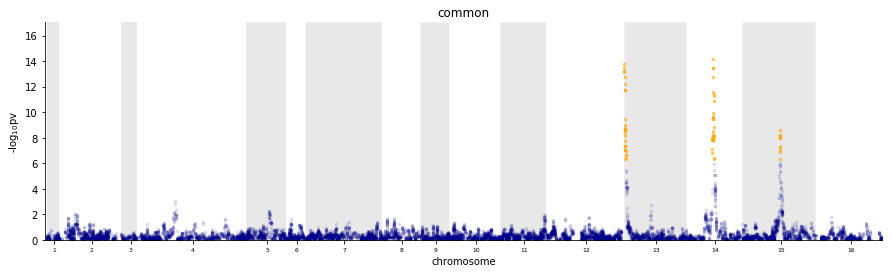

In [32]:
pl.figure(figsize=[15,4])
pl.title('common')
lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_common['common'].values,
                       pos=positions,chrom=chromosomes)))

### Testing for a specific effect

For a specific effect test for trait $p$
the alternative model is set to have both a common and a specific effect
for transcript $p$ from the SNP while the null model has only a common effect.

It is a 1 degree of freedom test and,
in the particular case of $P=3$ traits and for $p=0$, it can be done by setting
\begin{equation}
\mathbf{A}_1^\text{(snp)} =
\begin{pmatrix}
  1 & 0 & 0 \\
  1 & 1 & 1
 \end{pmatrix}
\;\;\;,
\mathbf{A}_0^\text{(snp)} = \mathbf{1}_{1,3}
\end{equation}

Specific effect tests can be performed using the function ``limix.qtl.qtl_test_interaction_lmm_kronecker`` (see [here](https://limix.readthedocs.io/en/stable/qtl.html#limix.qtl.qtl_test_interaction_lmm_kronecker)).

In [33]:
Asnps0 = np.ones((1,P))     #the null model design matrix for the SNPs
Asnps1 = np.zeros((2,P))          #the alternative model design matrix for the SNPs
Asnps1[0,:] = 1.0       
Asnps1[1,1] = 1.0  
print("Design(0): \n"+str(Asnps0))
print("Design(Alt): \n"+str(Asnps1))

Design(0): 
[[1. 1. 1.]]
Design(Alt): 
[[1. 1. 1.]
 [0. 1. 0.]]


In [34]:
from limix.qtl import qtl_test_interaction_lmm_kronecker

pvalues_inter = qtl_test_interaction_lmm_kronecker(snps=snps,
                                                   phenos=phenotypes.values,
                                                   covs=covs,
                                                   Acovs=Acovs,
                                                   Asnps0=Asnps0,
                                                   Asnps1=Asnps1,
                                                   K1r=K1r)


Convert the P-values into a DataFrame:

In [35]:
pvalues_inter = pd.DataFrame(data=np.concatenate(pvalues_inter).T,
                             index=positions,
                             columns=["specific","null_common","alternative_any"])

### Manhattan plot

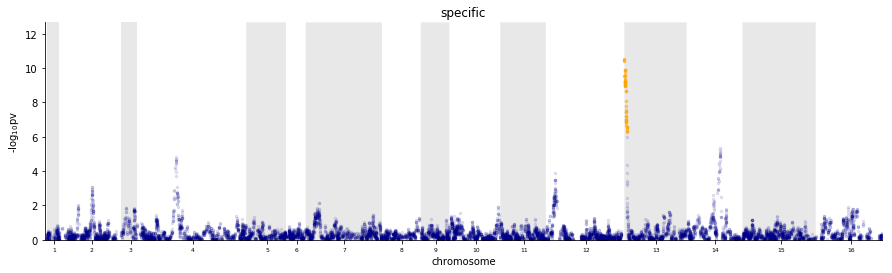

In [36]:
pl.figure(figsize=[15,4])
pl.title('specific')
lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_inter['specific'].values,
                       pos=positions,chrom=chromosomes,
                       alpha=0.1)))